<a href="https://colab.research.google.com/github/MartinaJoergensen/FirstCodes/blob/master/Tutorial6_GenModels_18_11_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import tensorflow as tf
import keras
from keras import layers, ops, Model, random

import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from sklearn.metrics import roc_curve, auc, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split

In [ ]:
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Normalize the dataset
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension
x_test = np.expand_dims(x_test, axis=-1)
# merge test and training
x_train = np.concatenate((x_train, x_test))
y_train = np.concatenate((y_train, y_test))
del x_test, y_test

In [ ]:
print(x_train.shape, y_train.shape)

(70000, 28, 28, 1) (70000,)


In [ ]:
# Split training data into 50% train, 25% validation, 25% test
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.5, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=42)

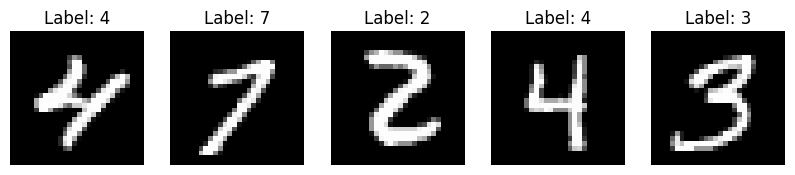

In [ ]:
# Visualize some digits from the dataset
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
digits = [1,2,3,-1,-2]
for i, ax in enumerate(axes):
    ax.imshow(x_test[digits[i]].reshape(28, 28), cmap='gray')
    ax.set_title(f"Label: {y_test[digits[i]]}")
    ax.axis('off')
plt.show()

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [ ]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))

# ----- Encoder -----
x = layers.Conv2D(8, (3, 3), use_bias=False,strides=2, padding='same')(encoder_inputs)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

x = layers.Conv2D(16, (3, 3), use_bias=False,strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(32, (3, 3), use_bias=False, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Conv2D(64, (3, 3), use_bias=False, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)

# Flatten the output of the convolutional layers before passing to Dense layers
x = layers.Flatten()(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
# encoder.summary() # Uncomment to see the encoder summary

# --------------------------------------------------------
# Decoder
# --------------------------------------------------------
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 2, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 2))(x)
x = layers.Conv2DTranspose(4, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(1, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 98)             │           294 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 7, 7, 2)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_11             │ (None, 14, 14, 4)      │            76 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_12             │ (None, 28, 28, 1)      │            37 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_13             │ (None, 28, 28, 1)      │            10 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 417 (1.63 KB)

 Trainable params: 417 (1.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # --------- MSE reconstruction loss ---------
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.mean_squared_error(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

In [ ]:
# [[[x],[y]],[[a],[b]]] ->[[x,y],[a,b]]

In [ ]:
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32")

# Train the autoencoder on the training data
history = vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
411/411 ━━━━━━━━━━━━━━━━━━━━ 28s 58ms/step - kl_loss: 0.0254 - loss: 166.7477 - reconstruction_loss: 166.7223
Epoch 2/30
411/411 ━━━━━━━━━━━━━━━━━━━━ 30s 72ms/step - kl_loss: 1.7144 - loss: 59.9026 - reconstruction_loss: 58.1882
Epoch 3/30
411/411 ━━━━━━━━━━━━━━━━━━━━ 34s 83ms/step - kl_loss: 2.0965 - loss: 50.9097 - reconstruction_loss: 48.8132
Epoch 4/30
411/411 ━━━━━━━━━━━━━━━━━━━━ 25s 61ms/step - kl_loss: 2.1319 - loss: 49.7162 - reconstruction_loss: 47.5843
Epoch 5/30
411/411 ━━━━━━━━━━━━━━━━━━━━ 40s 58ms/step - kl_loss: 2.2658 - loss: 48.8915 - reconstruction_loss: 46.6257
Epoch 6/30
411/411 ━━━━━━━━━━━━━━━━━━━━ 24s 58ms/step - kl_loss: 2.3907 - loss: 48.4041 - reconstruction_loss: 46.0134
Epoch 7/30
411/411 ━━━━━━━━━━━━━━━━━━━━ 24s 58ms/step - kl_loss: 2.4903 - loss: 47.9007 - reconstruction_loss: 45.4103
Epoch 8/30
411/411 ━━━━━━━━━━━━━━━━━━━━ 41s 58ms/step - kl_loss: 2.5657 - loss: 47.4806 - reconstruction_loss: 44.9149
Epoch 9/30
411/411 ━━━━━━━━━━━━━━━━━━━━ 24s 58

In [ ]:
def generate_random_images(decoder, latent_dim, n=10):
    # Sample random points in the latent space
    z_random = np.random.normal(size=(n, latent_dim))

    # Decode them into images
    generated = decoder.predict(z_random)

    # Plot
    plt.figure(figsize=(n, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        img = generated[i].squeeze()  # shape (28,28) or (28,28,1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


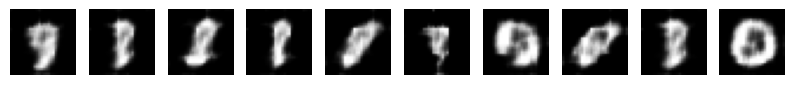

In [ ]:
generate_random_images(decoder, latent_dim=2, n=10)


In [ ]:
# ==========
# Hyperparameters
# ==========
latent_dim = 100
img_shape = (28, 28, 1)
batch_size = 128
epochs = 5  # change as you like


In [ ]:
# ==========
# Generator
# ========== #plain GAN
def build_generator(latent_dim):
    noise = layers.Input(shape=(latent_dim,))
    x = layers.Dense(7 * 7 * 128)(noise)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Reshape((7, 7, 128))(x)

    x = layers.Conv2DTranspose(64, kernel_size=4, strides=2, padding="same")(x)
    x = layers.LeakyReLU(0.2)(x)

    x = layers.Conv2DTranspose(32, kernel_size=4, strides=2, padding="same")(x)
    x = layers.LeakyReLU(0.2)(x)

    # Output: 28x28x1, values in [0,1] using sigmoid                   \/ <- PIXEL BY PIXEL
    img = layers.Conv2D(1, kernel_size=3, padding="same", activation="sigmoid")(x)

    return Model(noise, img, name="generator")

In [ ]:
# ==========
# Discriminator
# ==========
def build_discriminator(img_shape):
    img_input = layers.Input(shape=img_shape)

    x = layers.Conv2D(32, kernel_size=3, strides=2, padding="same")(img_input)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(64, kernel_size=3, strides=2, padding="same")(x)
    x = layers.LeakyReLU(0.2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(64)(x)
    x = layers.LeakyReLU(0.2)(x)
    validity = layers.Dense(1, activation="sigmoid")(x)

    return Model(img_input, validity, name="discriminator")


In [ ]:
generator = build_generator(latent_dim)
discriminator = build_discriminator(img_shape)

discriminator.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    metrics=["accuracy"],
)


In [ ]:
# ==========
# Combined model (Generator + frozen Discriminator)
# ==========
discriminator.trainable = False

z = layers.Input(shape=(latent_dim,))
img = generator(z)
valid = discriminator(img)

combined = Model(z, valid, name="combined")
combined.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
)

#just the casual def
# combined = Model(z, valid, name="combined")
# combined.compile(
#     loss="binary_crossentropy",
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
# )


In [ ]:
# ==========
# Training loop
# ==========

# Use your x_train from the split you did earlier
X_real = x_train.astype("float32")   # already in [0,1] and shape (28,28,1)

half_batch = batch_size // 2
steps_per_epoch = X_real.shape[0] // batch_size

for epoch in range(1, epochs + 1):
    for step in range(steps_per_epoch):

        # ---- Train Discriminator ----
        # Real images
        #shuffling
        idx = np.random.randint(0, X_real.shape[0], half_batch)
        real_imgs = X_real[idx]

        # Fake images
        noise = np.random.normal(0, 1, (half_batch, latent_dim))
        fake_imgs = generator.predict(noise, verbose=0)

        # Labels: real=1, fake=0
        real_y = np.ones((half_batch, 1))
        fake_y = np.zeros((half_batch, 1))

        d_loss_real = discriminator.train_on_batch(real_imgs, real_y)
        d_loss_fake = discriminator.train_on_batch(fake_imgs, fake_y)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # ---- Train Generator ----
        # Wants discriminator to think generated images are real (label=1)
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        valid_y = np.ones((batch_size, 1))

        g_loss = combined.train_on_batch(noise, valid_y)

    print(f"Epoch {epoch}/{epochs} - D loss: {d_loss[0]}, D acc: {d_loss[1]*100}%, G loss: {g_loss}")


/usr/local/lib/python3.12/dist-packages/keras/src/backend/tensorflow/trainer.py:83: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 1/5 - D loss: 0.8219877481460571, D acc: 33.46416473388672%, G loss: 0.4946838915348053
Epoch 2/5 - D loss: 0.9068174362182617, D acc: 33.63348388671875%, G loss: 0.40707555413246155
Epoch 3/5 - D loss: 0.9430960416793823, D acc: 33.43225860595703%, G loss: 0.3721766173839569
Epoch 4/5 - D loss: 0.96340012550354, D acc: 33.40179443359375%, G loss: 0.35313180088996887
Epoch 5/5 - D loss: 0.9764657020568848, D acc: 33.381229400634766%, G loss: 0.34106457233428955


In [ ]:
# ==========
# Generate some samples
# ==========
import matplotlib.pyplot as plt

def show_generated_images(generator, n=25):
    noise = np.random.normal(0, 1, (n, latent_dim))
    gen_imgs = generator.predict(noise, verbose=0)

    gen_imgs = gen_imgs.squeeze()  # (n, 28, 28)
    plt.figure(figsize=(5,5))
    for i in range(n):
        plt.subplot(5, 5, i+1)
        plt.imshow(gen_imgs[i], cmap="gray")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

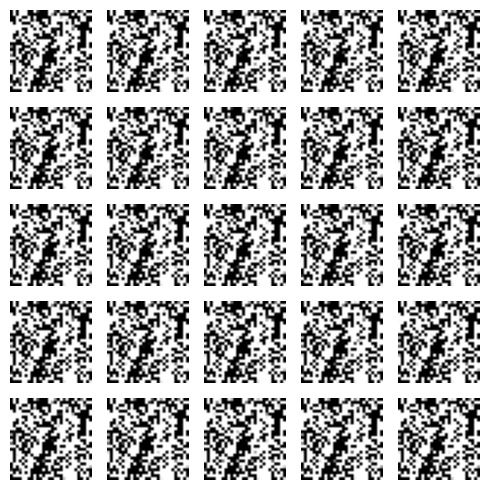

In [ ]:
show_generated_images(generator, n=25)